## Installing dependencies

In [1]:
!pip install ultralytics deepface opencv-python-headless scikit-learn numpy matplotlib

## Importing necessary files

In [2]:
from ultralytics import YOLO
from deepface import DeepFace
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

## Connectng with google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading yolov8n-face model from drive

In [4]:
# Load face detection model
yolo_model = YOLO('/content/drive/MyDrive/pratik/yolov8n-face.pt')

## Detecting faces from dataset

In [5]:
dataset_path = '/content/drive/MyDrive/pratik/dataset'

X, y = [], []

for person_name in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person_name)
    if not os.path.isdir(person_folder):
        continue

    for img_name in os.listdir(person_folder):
        img_path = os.path.join(person_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Detect face using YOLO
        results = yolo_model.predict(source=img, verbose=False)
        boxes = results[0].boxes.xyxy.cpu().numpy()

        if len(boxes) > 0:
            x1, y1, x2, y2 = map(int, boxes[0])
            face = img[y1:y2, x1:x2]
            face = cv2.resize(face, (160, 160))
            X.append(face)
            y.append(person_name)

X = np.array(X)
y = np.array(y)
print(f"Collected {len(X)} faces from {len(np.unique(y))} people.")

Collected 150 faces from 3 people.


## Representing detected faces into encodings

In [6]:
embeddings = []
for face in X:
    embedding = DeepFace.represent(face, model_name='ArcFace', enforce_detection=False)
    embeddings.append(embedding[0]['embedding'])

embeddings = np.array(embeddings)
print("Embedding shape:", embeddings.shape)

Embedding shape: (150, 512)


# Training a model

In [7]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(embeddings, y_encoded, test_size=0.2, random_state=42)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Save model
with open('face_recognition_svm.pkl', 'wb') as f:
    pickle.dump((clf, label_encoder), f)
!mv /content/face_recognition_svm.pkl /content/drive/MyDrive/pratik/face_recognition_svm.pkl

Accuracy: 1.0


## Recognize face from video but output is in frames

In [ ]:
from google.colab.patches import cv2_imshow
# Load trained model
with open('/content/drive/MyDrive/pratik/face_recognition_svm.pkl', 'rb') as f:
    clf, label_encoder = pickle.load(f)

video_path = '/content/drive/MyDrive/pratik/1st.mp4'
cap = cv2.VideoCapture(video_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = yolo_model.predict(source=frame, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy()

    for (x1, y1, x2, y2) in boxes:
        face = frame[int(y1):int(y2), int(x1):int(x2)]
        face = cv2.resize(face, (160, 160))

        embedding = DeepFace.represent(face, model_name='ArcFace', enforce_detection=False)
        emb = np.array(embedding[0]['embedding']).reshape(1, -1)

        pred = clf.predict(emb)[0]
        name = label_encoder.inverse_transform([pred])[0]

        # Draw box and name
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, name, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# recognize faces from image

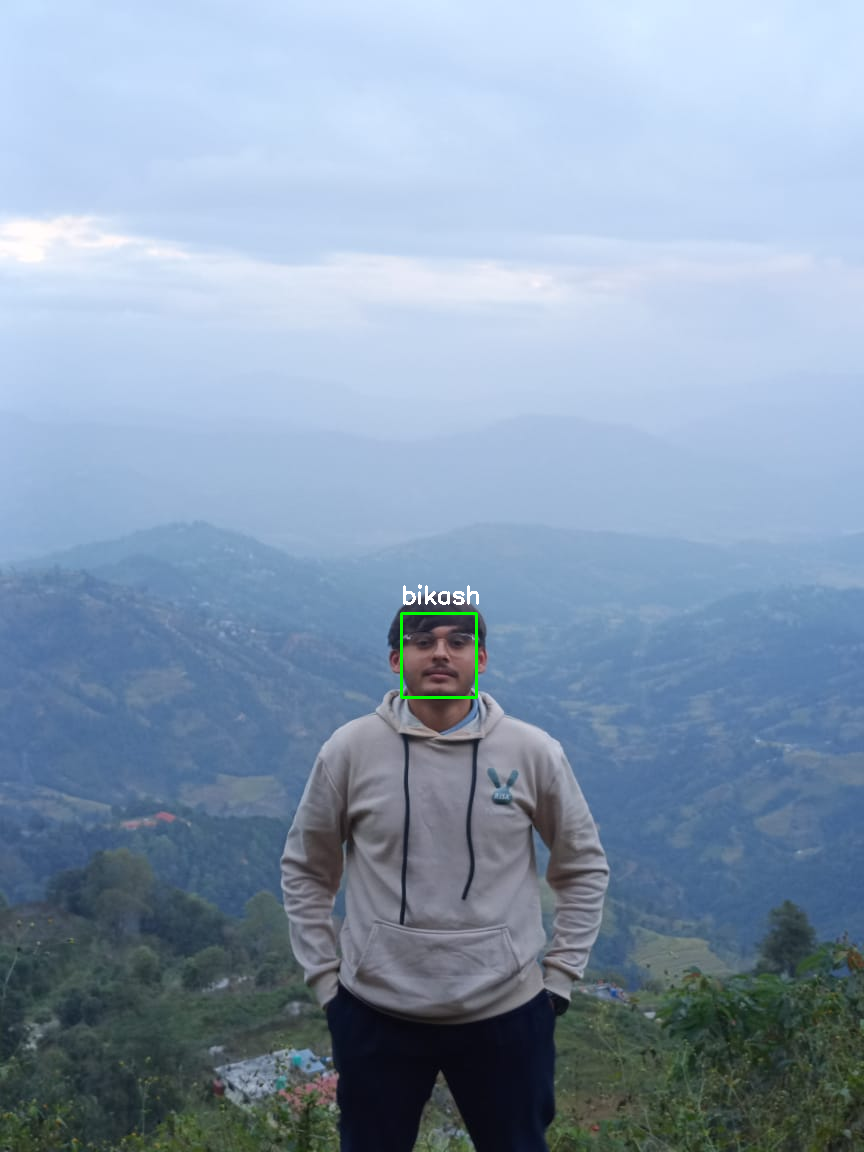

In [11]:
from google.colab.patches import cv2_imshow
# === Load trained recognition model ===
with open('/content/drive/MyDrive/pratik/face_recognition_svm.pkl', 'rb') as f:
    clf, label_encoder = pickle.load(f)

# # === Load YOLOv8 face detector ===
# yolo_model = YOLO('yolov8n-face.pt')

# === Load test image ===
image_path = '/content/drive/MyDrive/pratik/test_images/bikash(3).jpg'
frame = cv2.imread(image_path)

# === Detect faces ===
results = yolo_model.predict(source=frame, verbose=False)
boxes = results[0].boxes.xyxy.cpu().numpy()

for (x1, y1, x2, y2) in boxes:
    # Crop and preprocess face
    face = frame[int(y1):int(y2), int(x1):int(x2)]
    face = cv2.resize(face, (160, 160))

    # Extract face embedding
    embedding = DeepFace.represent(face, model_name='ArcFace', enforce_detection=False)
    emb = np.array(embedding[0]['embedding']).reshape(1, -1)

    # Predict identity
    pred = clf.predict(emb)[0]
    name = label_encoder.inverse_transform([pred])[0]

    # Draw name and bounding box
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(frame, name, (int(x1), int(y1)-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

# === Display result ===
cv2_imshow(frame)
cv2.waitKey(0)
cv2.destroyAllWindows()